In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.pandas
import montecarlo as mc
import seaborn as sns
import panel as pn
from panel.interact import interact
import random
from iexfinance.stocks import get_historical_data
import iexfinance as iex
from ta import *

import os
import json
from urllib.request import Request, urlopen

ModuleNotFoundError: No module named 'ta'

In [70]:
tickers_dict = {"index":["VOO"],
                "crypto":['BTC', 'ETH', 'XRP']}
years = 2
data_start_date = datetime.now() + timedelta(-365*years)

In [71]:
portfolio_hist_prices = mc.get_historic_data(ticker = tickers_dict["index"], 
                                             start_date = data_start_date)
#portfolio_hist_prices.head()

In [72]:
btc_daily_price = mc.get_crypto_daily_price(tickers_dict["crypto"],limit=years*365)
#btc_daily_price.head()

In [73]:
portfolio_hist_prices = pd.concat([portfolio_hist_prices,btc_daily_price],axis=1,join="inner")
portfolio_hist_prices.dropna(inplace=True)
portfolio_hist_prices = portfolio_hist_prices[(portfolio_hist_prices[portfolio_hist_prices.columns] != 0).all(axis=1)]
#portfolio_hist_prices.head()

In [74]:
portfolio_hist_prices = mc.normalize_dataframe(portfolio_hist_prices)
portfolio_daily_retn = portfolio_hist_prices.pct_change().copy()

#portfolio_daily_retn

In [75]:
def corr_plot(portfolio_daily_retn):
    
    title_font = {'family': 'monospace',
            'color':  'blue',
            'weight': 'bold',
            'size': 15,
            }
    correlated = portfolio_daily_retn.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(correlated, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    correlated_plot, ax = plt.subplots(figsize=(6, 4))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlated, mask=mask, cmap="coolwarm", vmax=1, vmin =-1, center=0,
                square=True, linewidths=.5, annot=True
                #cbar_kws={"shrink": .5}
               )
    plt.title(f"Correlation Map of Portfolio\n",fontdict=title_font)
    ax.set_facecolor("aliceblue")
    
    #correlated_plot = sns.heatmap(correlated, vmin=-1, vmax=1, annot=True,cmap="coolwarm") 
    plt.close()
    return pn.Pane(correlated_plot)


<script async type="text/javascript" src="{{https://widgets.coingecko.com/coingecko-coin-price-marquee-widget.js}}">
</script>
<coingecko-coin-price-marquee-widget  coin-ids="bitcoin,ethereum,litecoin,ripple,zcash" currency="usd" background-color="#ffffff" locale="en">
</coingecko-coin-price-marquee-widget>


In [123]:
def get_corr_pane(portfolio_daily_retn):
    header_text = pn.panel("<marquee> The latest news on crypto and finance here: BTC up 20,000.00% in last year, 7.77% today"
                           +" ETH up 400,000.00% in the last year, 9.99% today, "
                           +" Trump lost re-election due to poor results, Global peace achieved yesterday at UN, "
                           +" S&P500 down 10% in the last year, down 1.21%, today, "
                           +"cryptocurrencies are being used more than dollar for international trading, XRP up 27.89% today, "
                           +" Satoshi just gave away his millions of BTC to the most needed people in the developing world, "
                           +" military war on drugs has been replaced by an educational war "
                           +"on drugs and regulation of legal point of sales, drug cartels in bankruptcy, "
                           +" Colombians achieved peace for first time in more than 60 years...</marquee>", 
                           align = "center")

    side_text = pn.pane.Markdown(
            '''
<div style="background-color:black;color:white;"> <h1>  <style>
body {
    background-color: #d24dff;
}

</style>
We can use HTML styling now </h1>
</div>
<h2> Some sub title </h2> 
<p> And here we go with the test: We are building the coolest dashboard on earth since 2020.</p>
''',
        align= "center", max_width = 180)
    
    lower_text = pn.pane.Markdown('''
# Lower Text
## Some sub title

And here we go with the test: We are building the coolest dashboard on earth since 2020.
        ''',
                                  align= "start",
                                  width_policy = "max",
                                 )###??????????
    #WARNING:param.Markdown11741: Setting non-parameter attribute
    #max_with=5 using a mechanism intended only for parameters

    middle_row = pn.Row( side_text, corr_plot(portfolio_daily_retn), width_policy="fit")
    
    
    corr_pane = pn.Column(header_text,middle_row,lower_text,align="center")
    
    return corr_pane
    

Column(align='center')
    [0] Markdown(str, align='center')
    [1] Row(width_policy='fit')
        [0] Markdown(str, align='center', max_width=180)
        [1] Matplotlib(Figure)
    [2] Markdown(str, width_policy='max')
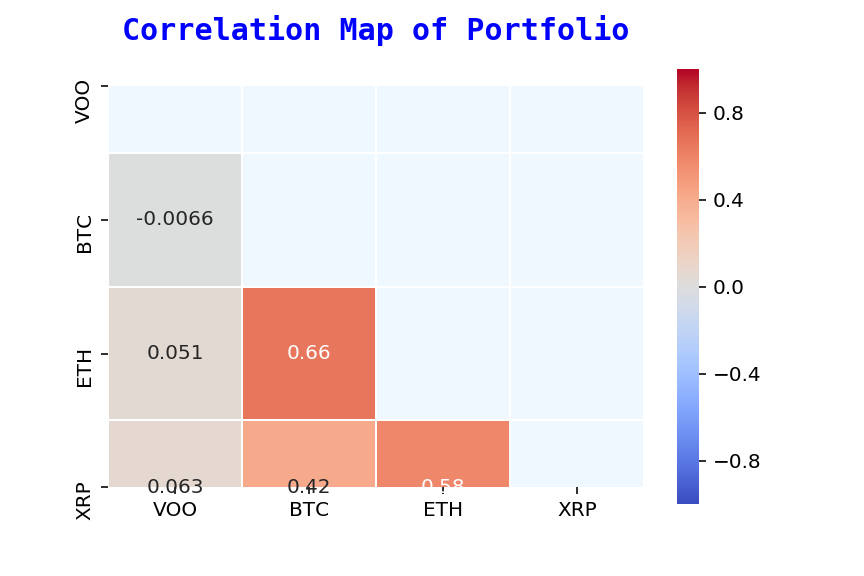

In [124]:
get_corr_pane(portfolio_daily_retn)

In [108]:
def sharp_rt_plot(portfolio_daily_retn):
    
    title_font = {'family': 'monospace',
            'color':  'blue',
            'weight': 'bold',
            'size': 15,
            }
    label_font = {'family': 'monospace',
            'color':  'green',
            'weight': 'bold',
            'size': 12,
            }
   # bar_colors=["orange","plum","yellowgreen","indigo","wheat","salmon","lightblue","purple","gold",
    #           "cornflowerblue","mediumslateblue","seagreen","peru"]
    bar_colors=["midnightblue","royalblue","indigo","darkcyan","darkgreen","maroon",
               "purple","darkorange","slategray","forestgreen"]

    sharp_ratios = portfolio_daily_retn.mean()*np.sqrt(252)/portfolio_daily_retn.std()
    
    sr_plot = plt.figure();
    plt.bar(x = sharp_ratios.index, height=sharp_ratios, color=random.sample(bar_colors,len(sharp_ratios.index)))
    plt.title(f"Sharp Ratios of Portfolio\n",fontdict=title_font)
    plt.ylabel("Sharp Ratio",fontdict=label_font)
    plt.xlabel("Assets",fontdict=label_font)
    plt.axhline(sharp_ratios.mean(), color='r')
    
    
    plt.close()
    return pn.Pane(sr_plot)

Matplotlib(Figure)
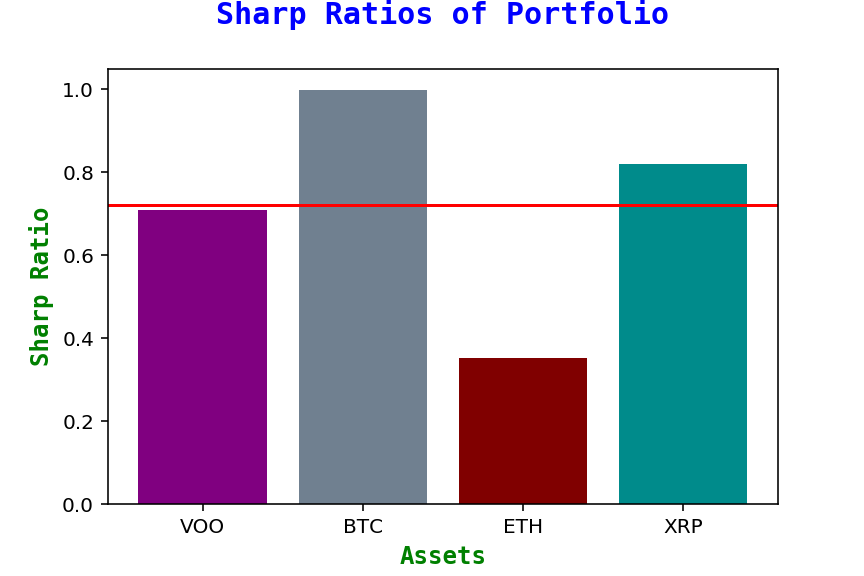

In [79]:
plot = sharp_rt_plot(portfolio_daily_retn)
plot

In [80]:


def plot_mont_carl(monte_carlo_sim):
    plot_title = f"Monte-Carlo Simulation of Portfolio"
    monte_carlo_sim_plot = monte_carlo_sim.hvplot(title=plot_title,figsize=(18,10),legend=False)
    return monte_carlo_sim_plot

In [81]:
def get_conf_interval(db,q=[0.05, 0.95]):
    confidence_interval = db.iloc[-1].quantile(q=q)
    return confidence_interval

In [82]:
def plot_conf(values=None,conf=[0,0]):
    bar_colors=["midnightblue","royalblue","indigo","black","darkcyan","darkgreen",
               "purple","darkorange","slategray"]
    conifidence_plot = plt.figure(figsize=(12,8));
    #plt.plot(values,kind='hist', density=True, bins=20)
    plt.hist(x = values,bins=20, color = random.choice(bar_colors))
    plt.axvline(conf.iloc[0], color='r')
    plt.axvline(conf.iloc[1], color='r')
    plt.close()
    return pn.Pane(conifidence_plot)

#### **New Code for TA functions**
_Christian_

---

In [83]:
def get_crypto_olhc(crypto_ticker, allData=False,limit = 90):
    """
    Returns a dataframe with all features needed for ta lib see
    https://technical-analysis-library-in-python.readthedocs.io/en/latest/ for more information about ta for python. 
    Arguments:
    cryptoticker: Crypto ticker in string format.
    allData: if True, gets all historical data available and ignores argument "limit".
    By default it is False.
    limit: the days from now to get the historical data. By default it's 90.
    """
    api_key = os.getenv("CC_API")

    if allData:
        url = f"https://min-api.cryptocompare.com/data/v2/histoday?fsym={crypto_ticker}&tsym=USD&allData=true&api_key={api_key}"
    else:
        url = f"https://min-api.cryptocompare.com/data/v2/histoday?fsym={crypto_ticker}&tsym=USD&limit={limit}&api_key={api_key}"

    raw_data = mc.read_json(url)
    crypto_df = pd.DataFrame(raw_data['Data']['Data'])
    crypto_df['time'] = pd.to_datetime(crypto_df['time'],unit='s')
    ta_df = add_all_ta_features(crypto_df, "open", "high", "low", "close", "volumefrom", fillna=True)      

    return ta_df

In [84]:
ta_df = get_crypto_olhc('ZEC', allData=False, limit=30)
ta_df = get_crypto_olhc('ZEC', allData=False, limit=30)

In [85]:
ta_df.head()

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,volume_adi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
0,2019-08-21,50.49,48.58,52.17,581228.21,29043622.85,49.97,multiply,BTC,240226.459268,...,100.000000,100.000000,81.875422,72.774869,72.774869,-27.225131,0.0,4.932769,0.000000,0.000000
1,2019-08-22,51.51,49.46,49.97,496190.40,25168083.16,50.72,multiply,BTC,378508.653969,...,100.000000,100.000000,73.368745,73.037543,72.906206,-26.962457,0.0,1.500901,1.489748,1.500901
2,2019-08-23,52.99,48.98,50.72,440900.01,22504697.17,51.04,multiply,BTC,125855.239844,...,100.000000,100.000000,63.489884,55.782313,67.198242,-44.217687,0.0,0.630915,0.628933,2.141285
3,2019-08-24,50.98,49.45,51.04,365029.80,18354956.52,50.28,multiply,BTC,43110.117912,...,80.654144,92.340502,61.783557,38.548753,55.789536,-61.451247,0.0,-1.489028,-1.500226,0.620372
4,2019-08-25,51.14,50.03,50.28,366013.73,18378209.76,50.21,multiply,BTC,-216290.970403,...,67.501911,87.362792,57.434119,36.961451,43.764172,-63.038549,0.0,-0.139220,-0.139317,0.480288


In [86]:
def bb_plot(df):
    bb_plot = plt.figure(figsize=(12,8));
    plt.plot(df.close)
    plt.plot(df.volatility_bbh, label='High BB')
    plt.plot(df.volatility_bbl, label='Low BB')
    plt.plot(df.volatility_bbm, label='EMA BB')
    plt.title('Bollinger Bands')
    plt.legend()
    plt.close()
    return pn.Pane(bb_plot)

In [87]:
def ichi_plot(df):
    ichi_plot = plt.figure(figsize=(12,8));
    plt.plot(df.close)
    plt.plot(df.trend_ichimoku_a, label='Ichimoku a')
    plt.plot(df.trend_ichimoku_b, label='Ichimoku b')
    plt.title('Ichimoku Kinko Hyo')
    plt.legend()
    plt.close()
    return pn.Pane(ichi_plot)

In [88]:
def ema_plot(df):
    ema_plot = plt.figure(figsize=(12,8));
    plt.plot(df.close)
    plt.plot(df.volatility_bbm, label='EMA BB')
    plt.title('Exponential Moving Average')
    plt.legend()
    plt.close()
    return pn.Pane(ema_plot)

In [89]:
def macd_plot(df):
    macd_plot = plt.figure(figsize=(12,8));
    plt.plot(df.trend_macd, label='MACD');
    plt.plot(df.trend_macd_signal, label='MACD Signal')
    plt.plot(df.trend_macd_diff, label='MACD Difference')
    plt.title('MACD, MACD Signal and MACD Difference')
    plt.legend()
    plt.close()
    return pn.Pane(macd_plot)

#### End New Code for TA

---

# DASHBOARD TIME!!!

In [90]:
#print(portfolio_hist_prices.head())

In [91]:
portfolio_hist_prices = portfolio_hist_prices[(portfolio_hist_prices[portfolio_hist_prices.columns] != 0).all(axis=1)]
#portfolio_hist_prices.any()
#portfolio_hist_prices.head()

In [92]:
mc_sim = mc.monte_carlo_sim(portfolio_hist_prices,trials = 50)

In [93]:
risk_tabs = pn.Tabs(
    ("Correlation of portfolio",get_corr_pane(portfolio_daily_retn)),
    ("Sharp Ratios", sharp_rt_plot(portfolio_daily_retn)),
    background="whitesmoke"
)

In [94]:
montecarlo_tabs = pn.Tabs(
    ("monte Carlo Simulation",plot_mont_carl(mc_sim)),
    ("Confidence Intervals", plot_conf(mc_sim.iloc[-1],get_conf_interval(mc_sim))),
    background="whitesmoke"
)

In [95]:
techl_analysis_tabs = pn.Tabs(
    ("Exp. Moving Avg.",ema_plot(ta_df)),
    ("Bollinger Bands", bb_plot(ta_df)),
    ("MACD",macd_plot(ta_df)),
    ("Ichimoku Kinkō Hyō", ichi_plot(ta_df)),
    background="whitesmoke"
)

In [96]:
tabs = pn.Tabs(
    ("Risk",risk_tabs),
    ("Monte Carlo Simulation", montecarlo_tabs),
    ("Tecnical Analysis", techl_analysis_tabs),
    ("Report", "in construction"),
    tabs_location = "left",
    align = "start"
)
  

Tabs(tabs_location='left')
    [0] Tabs(background='whitesmoke')
        [0] Column(align='center')
            [0] Markdown(str, align='center')
            [1] Row(width_policy='fit')
                [0] Markdown(str, align='center', max_width=180)
                [1] Matplotlib(Figure)
            [2] Markdown(str, width_policy='max')
        [1] Matplotlib(Figure)
    [1] Tabs(background='whitesmoke')
        [0] HoloViews(NdOverlay, name='monte Carlo Simulation')
        [1] Matplotlib(Figure)
    [2] Tabs(background='whitesmoke')
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
    [3] Markdown(str, name='Report')
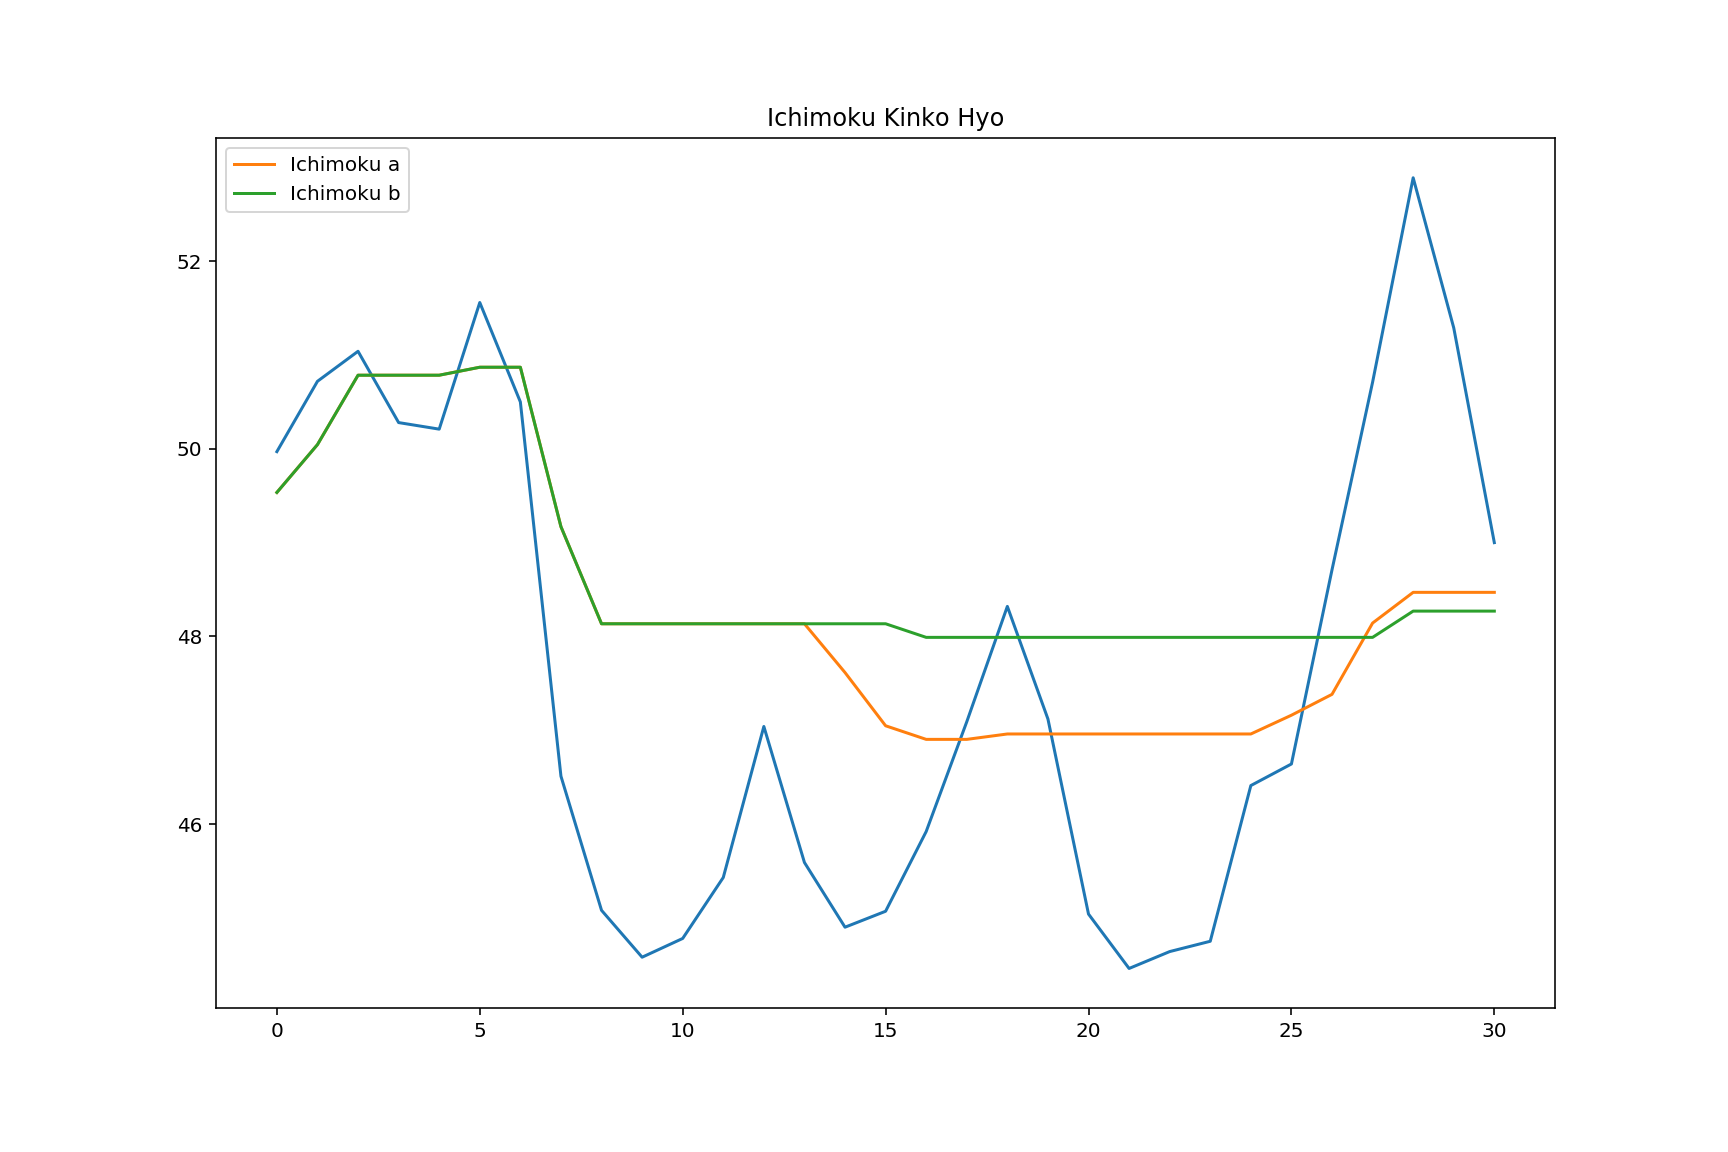
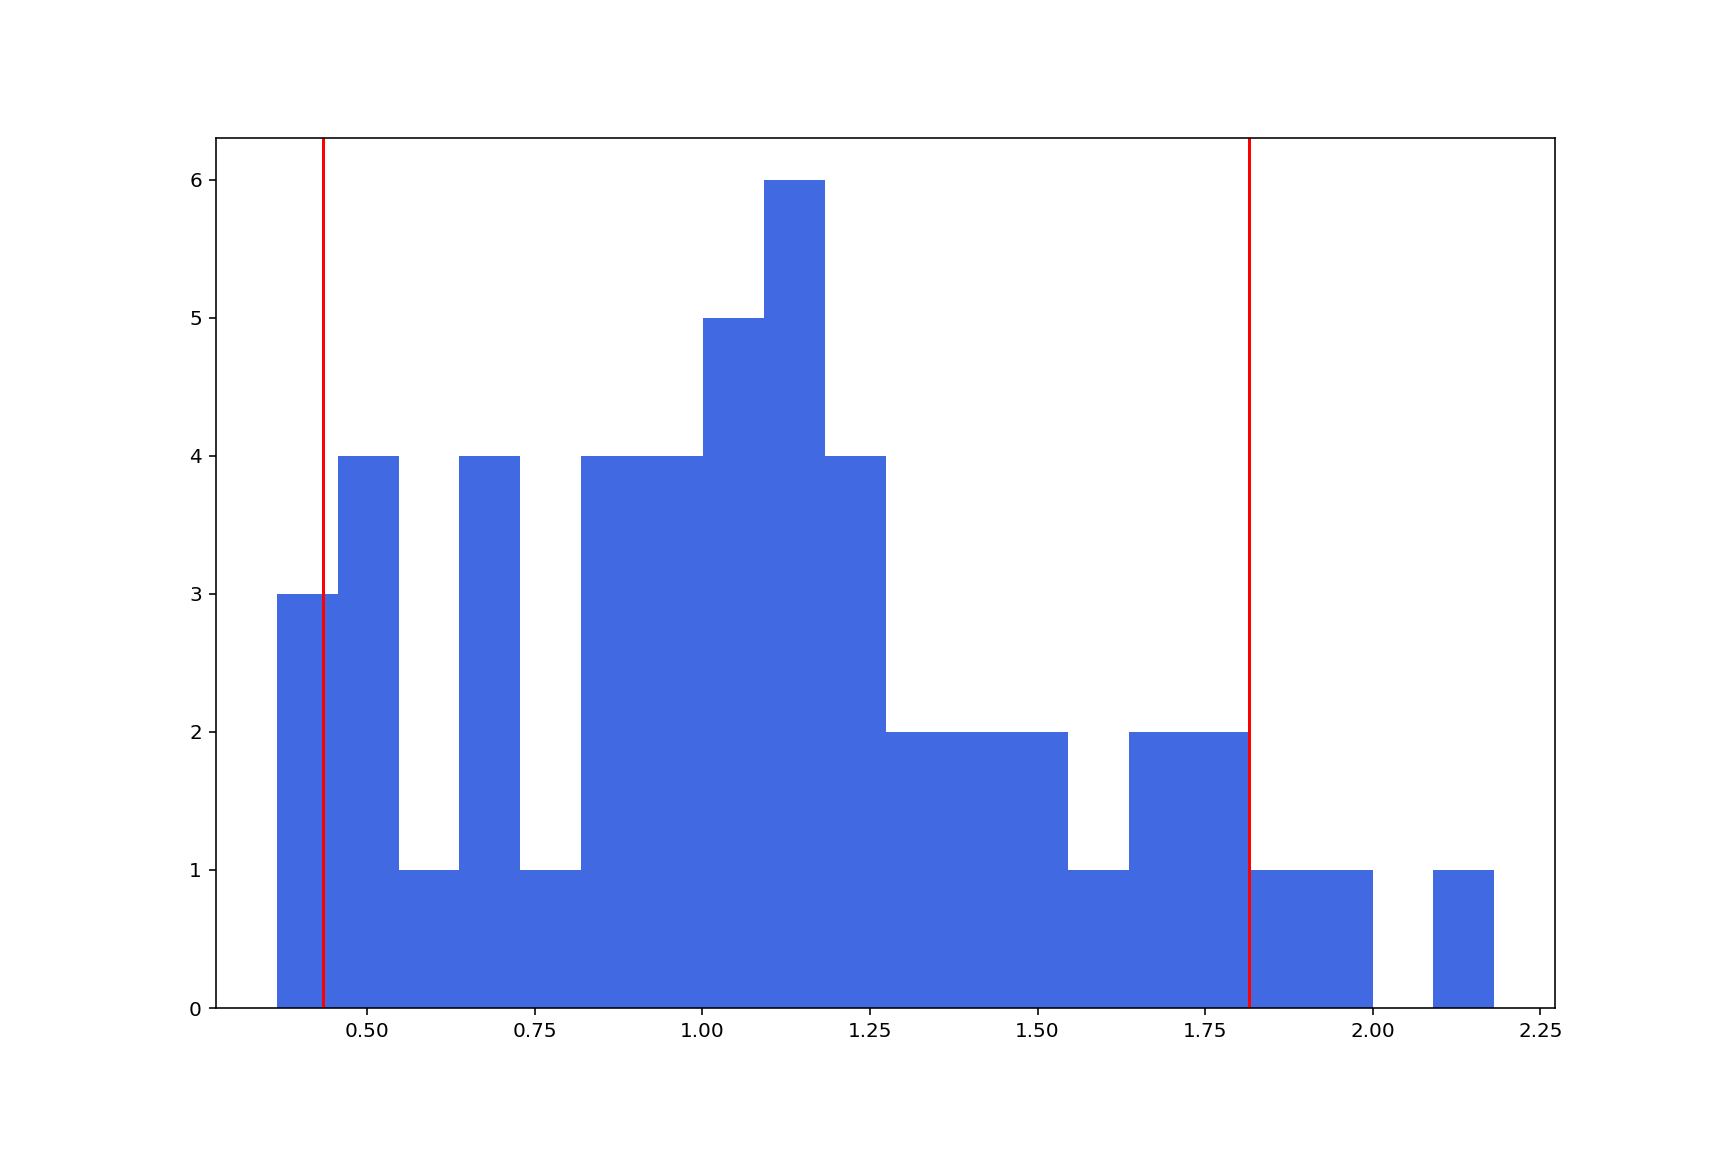
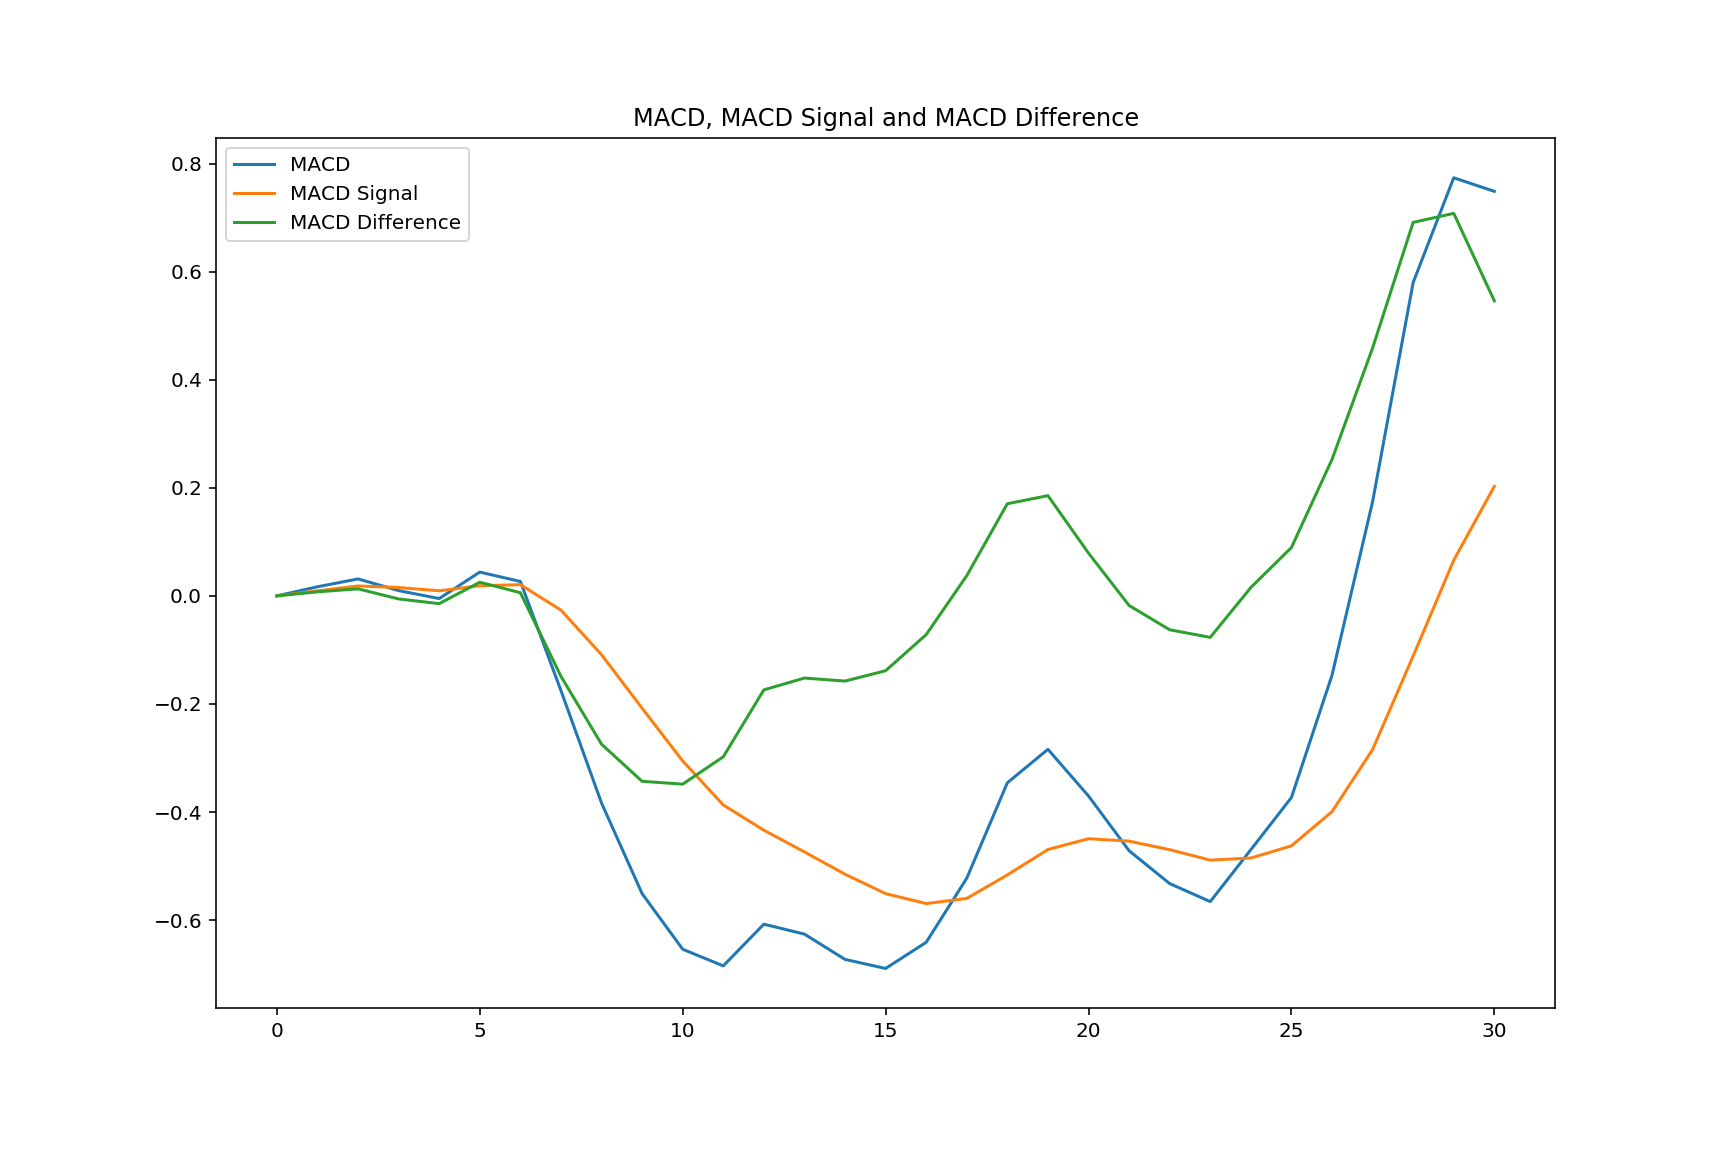
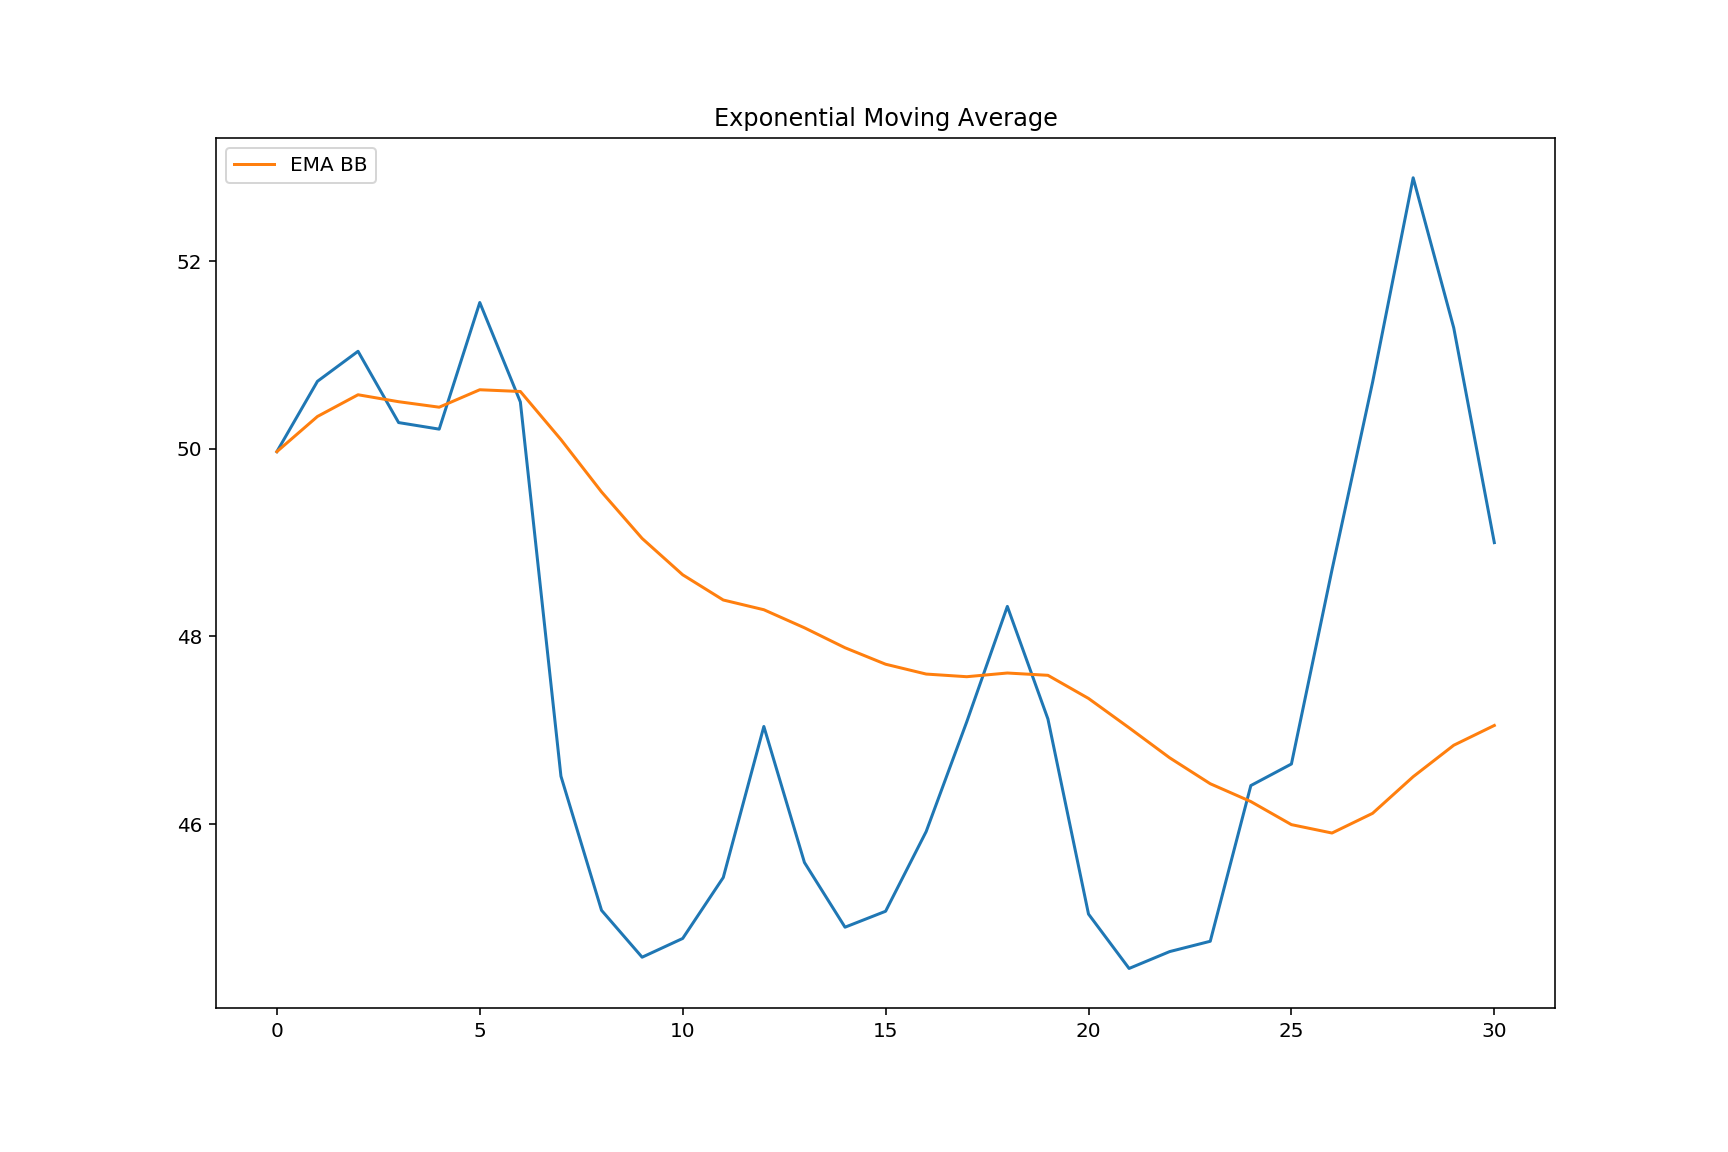
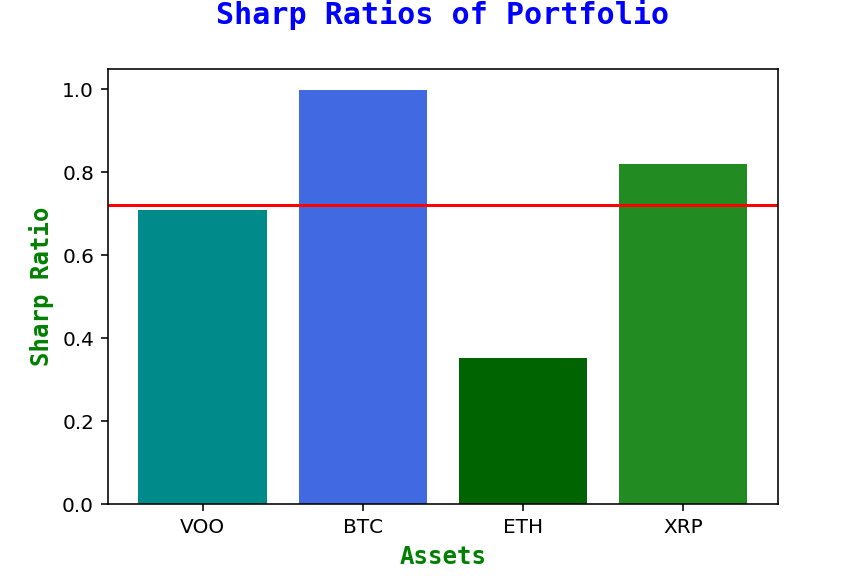
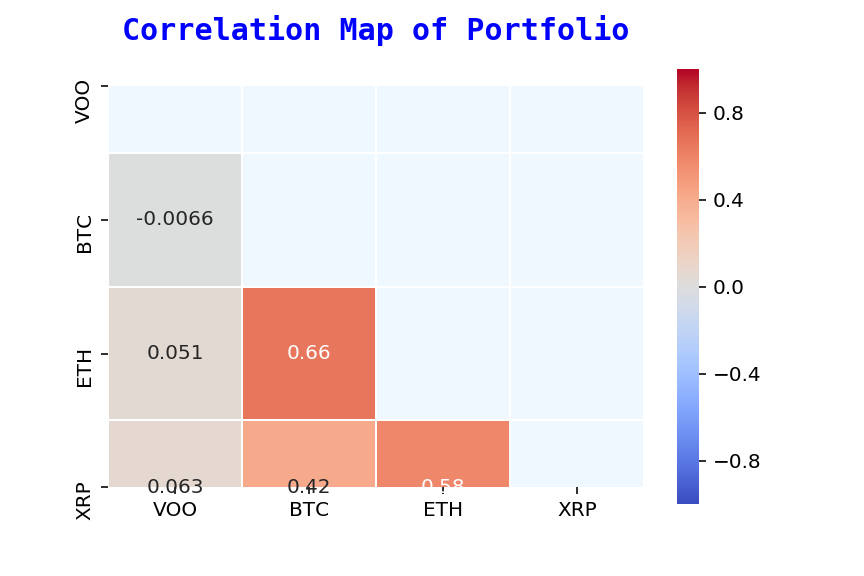
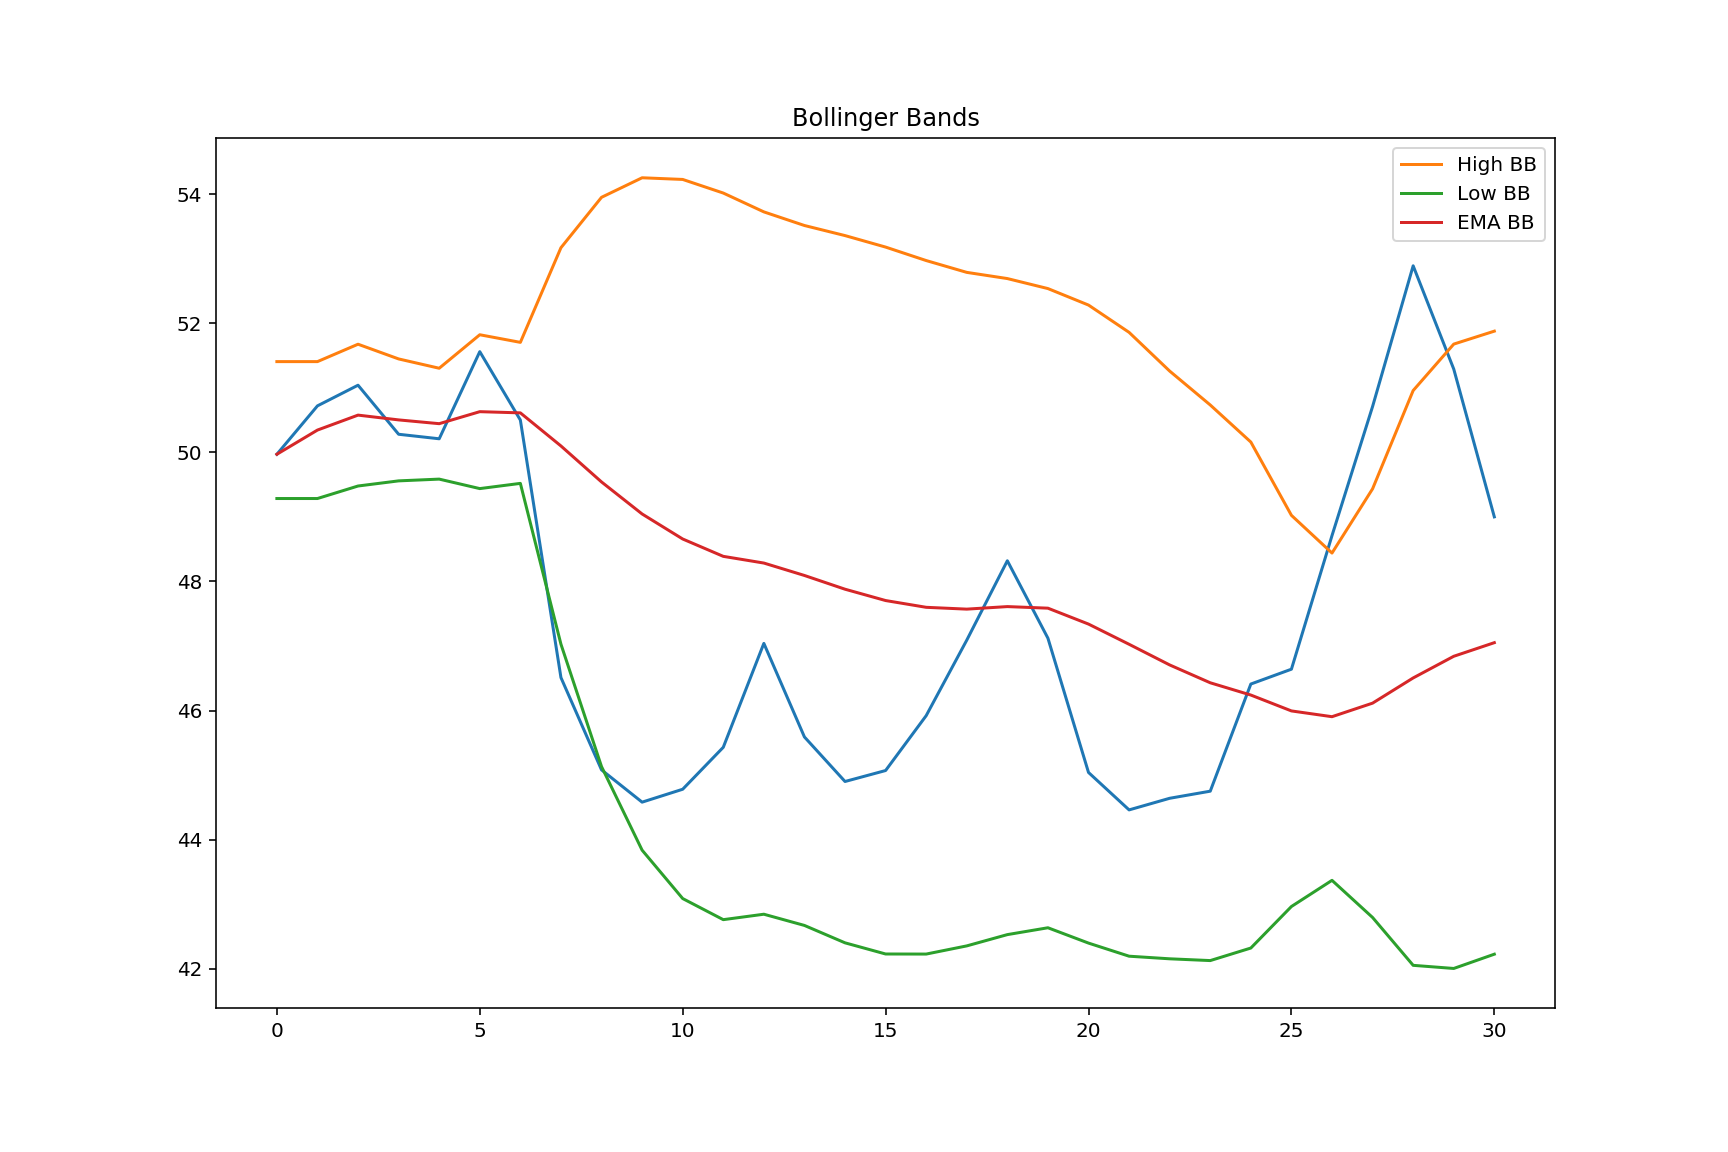

In [97]:
  
panel = tabs

panel